<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer" />

In this notebook we will take the first steps with training a BDT with `xgboost`, then translating it to HLS code for FPGA with `conifer`

Key concepts:
- model training
- model evaluation
- `conifer` configuration and conversion
- model emulation
- model synthesis
- accelerator creation

For some use cases, the Forest Processing Unit might be an easier entry point as no FPGA synthesis is required for supported boards. Read more about the FPU here: https://ssummers.web.cern.ch/conifer/fpu.html

In [2]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import conifer
import json

import sys
import os
# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial"))
import plotting

# Simulate sourcing the script to set variables (as a fallback)
os.environ['XILINX_VITIS'] = '/opt/local/Vitis_HLS/2024.1'  # Adjust this path as needed
# Update the PATH variable
os.environ['PATH'] = os.path.join(os.environ['XILINX_VITIS'], 'bin') + ':' + os.environ.get('PATH', '')
# enable more output from conifer
import logging

logging.basicConfig(stream=sys.stdout, level=logging.WARNING)
logger = logging.getLogger('conifer')
logger.setLevel('DEBUG')

# create a random seed at we use to make the results repeatable
seed = int('hls4ml-tutorial'.encode('utf-8').hex(), 16) % 2**31

print(f'Using conifer version {conifer.__version__}')

Could not import conifer ydf converter


runtime module could not be imported. Interacting with accelerators will not be possible.
runtime module could not be imported. Interacting with FPUs will not be possible.


Using conifer version 1.5


# Load dataset

Load the jet tagging dataset.

**Note**: you need to run part1 first.

In [3]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val_one_hot = np.load('y_train_val.npy')
y_test_one_hot = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

We need to transform the test labels from the one-hot encoded values to labels

In [4]:
le = LabelEncoder().fit(classes)
ohe = OneHotEncoder().fit(le.transform(classes).reshape(-1, 1))
y_train_val = ohe.inverse_transform(y_train_val_one_hot.astype(int))
y_test = ohe.inverse_transform(y_test_one_hot)

# Train a BDT
We'll use `xgboost`'s `XGBClassifier` with:

| Parameter | Explanation |
| --- | --- |
| `n_estimators=25` | 25 trees |
| `max_depth=5` | maximum tree depth of 5 |

In [5]:
clf = xgb.XGBClassifier(n_estimators=25, max_depth=5, learning_rate=1.0, random_state=seed).fit(X_train_val, y_train_val)

# Validate performance
Now we check whether the trained model is any good. We'll plot the ROC curve.

2025-01-23 13:36:40.989715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


19688/19688 [==============================] - 13s 646us/step
Accuracy baseline:  0.69853
Accuracy xgboost:   0.81969


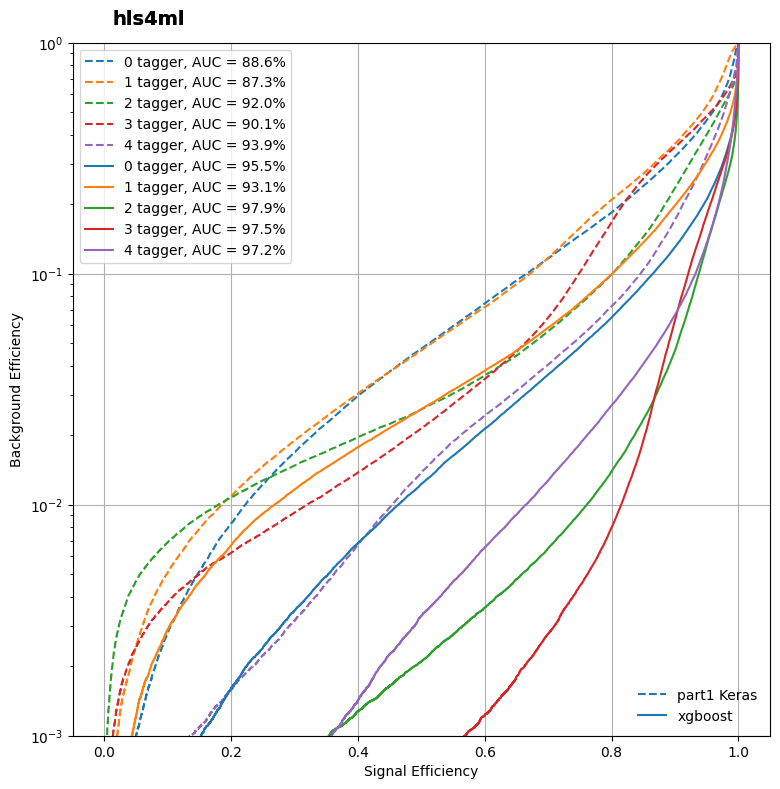

In [6]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# load the KERAS model from part 1
model_ref = load_model('/home/hep/lr1424/hls4ml-tutorial/model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

# compute predictions of the xgboost model
y_xgb = clf.predict_proba(X_test)
print(f'Accuracy baseline:  {accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_ref, axis=1)):.5f}')
print(f'Accuracy xgboost:   {accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_xgb, axis=1)):.5f}')

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test_one_hot, y_ref, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test_one_hot, y_xgb, classes, linestyle='-')

# add a legend
from matplotlib.lines import Line2D

lines = [
    Line2D([0], [0], ls='--'),
    Line2D([0], [0], ls='-'),
]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['part1 Keras', 'xgboost'], loc='lower right', frameon=False)
ax.add_artist(leg)

<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer" />

Now we'll convert this model to FPGA firmware with `conifer`. We first need to create a configuration in the form of a dictionary. The quickest way to get started is to create a default configuration from the intended target backend (`xilinxhls` for us). Each backend may have different configuration options, so getting the configuration this way helps enumerate the possible options.

We will print the configuration, modify it, and print it again. The modifications are:
- set the `OutputDirectory` to something descriptive
- set the `XilinxPart` to the part number of the FPGA on the Alveo U50

In [ ]:
cfg = conifer.backends.xilinxhls.auto_config()

# print the config
print('Default Configuration\n' + '-' * 50)
plotting.print_dict(cfg)
print('-' * 50)

# modify the config
cfg['OutputDir'] = '/home/hep/lr1424/hls4ml-tutorial/model_5/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'

# print the config again
print('Modified Configuration\n' + '-' * 50)
plotting.print_dict(cfg)
print('-' * 50)

Default Configuration
--------------------------------------------------
Backend:             xilinxhls
ProjectName:         my_prj
OutputDir:           my-conifer-prj
XilinxPart:          xcvu9p-flgb2104-2L-e
ClockPeriod:         5
Unroll:              True
AcceleratorConfig:   None
Precision:           ap_fixed<18,8>
--------------------------------------------------
Modified Configuration
--------------------------------------------------
Backend:             xilinxhls
ProjectName:         my_prj
OutputDir:           /home/hep/lr1424/hls4ml-tutorial/model_5/
XilinxPart:          xcu250-figd2104-2L-e
ClockPeriod:         5
Unroll:              True
AcceleratorConfig:   None
Precision:           ap_fixed<18,8>
--------------------------------------------------


## Convert and write
Convert the `xgboost` model to a `conifer` one, and print the `help` to see what methods it implements.
Then `write` the model, creating the specified output directory and writing all the HLS files to it. We also save the `xgboost` model itself.

#### Other converters:
`conifer` has converters for several popular BDT training libraries. Each one is used like: `conifer.converters.convert_from_<library>(model, config)`
The converters are:
- `sklearn`
- `xgboost`
- `ydf`
- `tmva`
- `onnx` (exposing `catboost` and `lightGBM`)

In [8]:
# convert the model to the conifer representation
conifer_model = conifer.converters.convert_from_xgboost(clf, cfg)
# print the help to see the API on the conifer_model
help(conifer_model)
# write the project (writing HLS project to disk)
conifer_model.write()
# save the conifer model - we can load this again later
clf.save_model('/home/hep/lr1424/hls4ml-tutorial/model_5/xgboost_model.json')

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 5, "n_trees": 25, "n_features": 53, "n_classes": 5}
Help on XilinxHLSModel in module conifer.backends.xilinxhls.writer object:

class XilinxHLSModel(conifer.model.ModelBase)
 |  XilinxHLSModel(ensembleDict, config, metadata=None)
 |  
 |  Method resolution order:
 |      XilinxHLSModel
 |      conifer.model.ModelBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, ensembleDict, config, metadata=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  build(self, reset=False, csim=False, synth=True, cosim=False, export=False, vsynth=False, bitfile=False, package=False, **bitfile_kwargs)
 |      Build the project, running the build function of the backend.
 |      
 |      Parameters
 |      ----------
 |      kwargs: keyword arguments of backend build method
 |      
 |      Returns
 |      ----------    
 |      success: bool
 |               True if the build com

## Explore
Browse the files in the newly created project directory to take a look at the HLS code.

The output of `!tree model_5` is:

```
model_5/
├── bridge.cpp
├── build_hls.tcl
├── firmware
│   ├── BDT.cpp
│   ├── BDT.h
│   ├── my_prj.cpp
│   ├── my_prj.h
│   └── parameters.h
├── hls_parameters.tcl
├── my_prj.json
├── my_prj_test.cpp
├── tb_data
└── vivado_synth.tcl
```

- files under `firmware` are the HLS implementation of the model
- `my_prj.json` is the saved converted `conifer` model that can be loaded again without the original `xgboost` model
- `tcl` scripts are used for synthesizing the project

## Emulate
Before starting the lengthy FPGA build process, we should validate that our conversion was successful and that the choice of precision was suitable with a bit-accurate emulation. To do this we need to run the HLS C++ code on the CPU with some test data first. This is like the HLS C Simulation step, but rather than writing a C++ testbench and invoking `vitis_hls` to run `csim`, `conifer` implements Python bindings for the HLS, just like `hls4ml`.

We first need to compile (which uses the C++ compiler), then we can make predictions

In [9]:
conifer_model.compile()

INFO:conifer.backends.xilinxhls.writer:Writing project to /home/hep/lr1424/hls4ml-tutorial/model_5
DEBUG:conifer.utils.misc:Including ap_ headers from XILINX_HLS: -I/opt/local//Vitis_HLS/2024.1//include
DEBUG:conifer.backends.xilinxhls.writer:Compiling with command g++ -O3 -shared -std=c++14 -fPIC $(/home/hep/lr1424/miniforge3/envs/hls4ml-tutorial/bin/python -m pybind11 --includes) -I/opt/local//Vitis_HLS/2024.1//include  bridge.cpp firmware/BDT.cpp firmware/my_prj.cpp -o conifer_bridge_1737639425.so


DEBUG:conifer.backends.xilinxhls.writer:Importing conifer_bridge_1737639425 from conifer_bridge_1737639425.so


In [10]:
y_hls = conifer_model.decision_function(X_test)

## Compare

Now we check whether the emulated predictions are good. To do this we'll plot the ROC curve again with the HLS predictions overlaid.

Accuracy baseline:  0.69853
Accuracy xgboost:   0.81969
Accuracy conifer:   0.71308


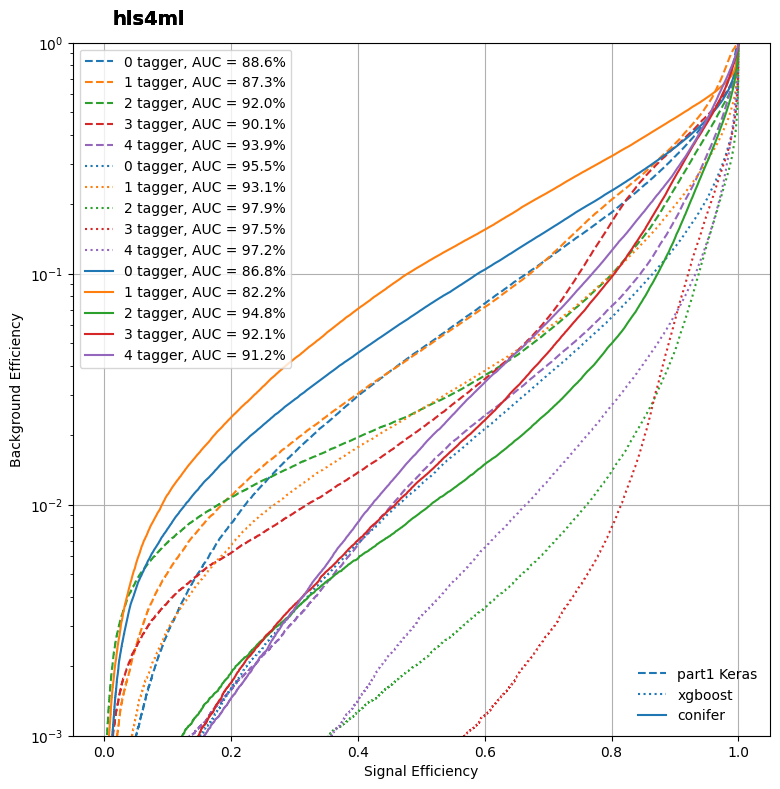

In [11]:
y_hls_proba = softmax(y_hls)  # compute class probabilities from the raw predictions

print(f'Accuracy baseline:  {accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_ref, axis=1)):.5f}')
print(f'Accuracy xgboost:   {accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_xgb, axis=1)):.5f}')
print(f'Accuracy conifer:   {accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_hls_proba, axis=1)):.5f}')


fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test_one_hot, y_ref, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test_one_hot, y_xgb, classes, linestyle=':')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test_one_hot, y_hls_proba, classes, linestyle='-')

# add a legend
from matplotlib.lines import Line2D

lines = [
    Line2D([0], [0], ls='--'),
    Line2D([0], [0], ls=':'),
    Line2D([0], [0], ls='-'),
]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['part1 Keras', 'xgboost', 'conifer'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Build
Now we'll run the Vitis HLS and Vivado synthesis. HLS C Synthesis compiles our C++ to RTL, performing scheduling and resource mapping. Vivado synthesis synthesizes the RTL from the previous step into a netlist, and produces a more realistic resource estimation. The latency can't change during Vivado synthesis, it's fixed in the RTL description.

After the build completes we can also browse the new log files and reports that are generated.

**Warning**: this step might take around 10 minutes

In [12]:
conifer_model.build(synth=True, vsynth=True)

INFO:conifer.backends.xilinxhls.writer:build starting 13:38:14
DEBUG:conifer.backends.xilinxhls.writer:build invoking vitis_hls with command "vitis_hls -f build_hls.tcl "reset=False csim=False synth=True cosim=False export=False" > build.log"
INFO:conifer.backends.xilinxhls.writer:build finished 13:42:53 - took 0:04:38.785730
INFO:conifer.backends.xilinxhls.writer:build starting 13:42:53
DEBUG:conifer.backends.xilinxhls.writer:build invoking vivado with command "vivado -mode batch -source vivado_synth.tcl > vivado_build.log"
INFO:conifer.backends.xilinxhls.writer:build finished 13:45:35 - took 0:02:42.197346


True

## Report
If the synthesis completed successfuly, we can extract the key metrics from the reports and print them out.
The section `"vsynth"` contains the report from the Vivado RTL synthesis, which is usually lower, and more realistic than the HLS report.

In [13]:
report = conifer_model.read_report()
plotting.print_dict(report)

latency:             2
interval:            1
lut:                 143774
ff:                  5025
vsynth
  lut:               36256
  ff:                3968


## Deployment with `pynq`

There are two main ways to deploy a BDT to an accelerator card with `conifer`:
- build a static accelerator with Xilinx HLS backend
- use the dynamic accelerator Forest Processing Unit (FPU)

Getting started with the FPU is straightforward. For a supported board, you will need only the converted model JSON, and a bitfile that can be downloaded from the conifer website. Read more about the FPU here: https://ssummers.web.cern.ch/conifer/fpu.html

However, without a physical device there's not much to show, so in this section we'll see how to deploy the model that we already trained as a static accelerator to a `pynq-z2` board.
We'll use the `AcceleratorConfig` part of the configuration that we previously left undefined.

In [14]:
pynq_model_cfg = conifer.backends.xilinxhls.auto_config()
pynq_model_cfg['OutputDir'] = '/home/hep/lr1424/hls4ml-tutorial/model_5_pynq'  # choose a new project directory
pynq_model_cfg['ProjectName'] = 'conifer_jettag'
pynq_model_cfg['AcceleratorConfig'] = {
    'Board': 'pynq-z2',  # choose a pynq-z2 board
    'InterfaceType': 'float',  # floating point for the data I/O (this is default)
}

# print the config
print('Modified Configuration\n' + '-' * 50)
print(json.dumps(pynq_model_cfg, indent=2))
print('-' * 50)

Modified Configuration
--------------------------------------------------
{
  "Backend": "xilinxhls",
  "ProjectName": "conifer_jettag",
  "OutputDir": "/home/hep/lr1424/hls4ml-tutorial/model_5_pynq",
  "XilinxPart": "xcvu9p-flgb2104-2L-e",
  "ClockPeriod": "5",
  "Unroll": true,
  "AcceleratorConfig": {
    "Board": "pynq-z2",
    "InterfaceType": "float"
  },
  "Precision": "ap_fixed<18,8>"
}
--------------------------------------------------


## Supported boards

Here we print the list of supported boards, so you can see what else works "out of the box". It's relatively easy to add other Zynq SoC or Alveo boards, for example to add an Alveo U50 card targeting `xilinx_u50_gen3x16_xdma_5_202210_1` platform:

```
u50 = conifer.backends.boards.AlveoConfig.default_config()
u50['xilinx_part'] = 'xcu50-fsvh2104-2-e'
u50['platform'] = 'xilinx_u50_gen3x16_xdma_5_202210_1'
u50['name'] = 'xilinx_u50_gen3x16_xdma_5_202210_1'
u50 = conifer.backends.boards.AlveoConfig(u50)
conifer.backends.boards.register_board_config(u50.name, u50)
```

In [15]:
# This is the full list of supported boards:
print(f'Supported boards: {conifer.backends.boards.get_available_boards()}')

Supported boards: ['kr260', 'kv260', 'pynq-z2', 'ultra96v2', 'zcu102', 'zcu104', 'xilinx_u200_gen3x16_xdma_2_202110_1']


### Load the model

We load the JSON for the conifer model we previously used, applying the new configuration just defined. We'll see that the FPGA part specified by the board overrides the `XilinxPart` specified in the default.

In [16]:
pynq_model = conifer.model.load_model('/home/hep/lr1424/hls4ml-tutorial/model_5/my_prj.json', new_config=pynq_model_cfg)
pynq_model.write()

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 5, "n_trees": 25, "n_features": 53, "n_classes": 5}
INFO:conifer.backends.xilinxhls.writer:Writing project to /home/hep/lr1424/hls4ml-tutorial/model_5_pynq


## Build the model

Now we run `build` again, running HLS Synthesis, Logic Synthesis and Place & Route, finally producing a bitfile and an archive of files that we'll need to run inference on the pynq-z2 board. 

**Warning**: this step might take around 20 minutes to complete.

The floorplan of the bitfile should like something like this, where the individual tree modules are highlighted in different colours:

<img src="./images/part5_floorplan.png" width="300" />

In [17]:
pynq_model.build(synth=True, bitfile=True, package=True)

INFO:conifer.backends.xilinxhls.writer:build starting 13:45:35
DEBUG:conifer.backends.xilinxhls.writer:build invoking vitis_hls with command "vitis_hls -f build_hls.tcl "reset=False csim=False synth=True cosim=False export=True" > build.log"
INFO:conifer.backends.xilinxhls.writer:build finished 13:53:17 - took 0:07:41.845280
INFO:conifer.backends.boards.boards:Building Zynq bitfile with command "vivado -mode batch -source build_bit.tcl  > vivado_build.log"


ERROR: [Board 49-71] The board_part definition was not found for tul.com.tw:pynq-z2:part0:1.0. The project's board_part property was not set, but the project's part property was set to xc7z020clg400-1. Valid board_part values can be retrieved with the 'get_board_parts' Tcl command. Check if board.repoPaths parameter is set and the board_part is installed from the tcl app store.


False

## Inference on pynq-z2

Running inference on the `pynq-z2` would look like this:
- download the `model_5/conifer_jettag.zip` archive from this notebook
- upload `conifer_jettag.zip` to the pynq-z2 device and unzip it
- start a jupyter notebook on the `pynq-z2` and run the following code:

```
import conifer
accelerator = conifer.backends.xilinxhls.runtime.ZynqDriver('conifer_jettag.bit', batch_size=1)
X = ... # load some data 
y_pynq = accelerator.decision_function(X)
```
